Manufactured Solution experiment based on SAND2000 - 1444

Test based on heat flux example in SAND2000 - 1444 Section 3

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from sympy import symbols, sin, exp, sqrt, init_printing

In [4]:
from sympy import simplify, lambdify 

In [5]:
from sympy.physics.vector import ReferenceFrame, dynamicsymbols, time_derivative, divergence, gradient

In [6]:
init_printing(use_unicode=True)

In [7]:
N = ReferenceFrame('N')

In [8]:
t = symbols('t')

# symbolic form

In [9]:
T0, R, t0, k0, rho0, Cp0 = symbols('T0 R t0 k0 rho0 Cp0')

In [10]:
T_sym = T0 * (1 + sin(N[0]/R)**2 * sin(2*N[1]/R)**2) * exp(t*(t0-t)/t0)

In [11]:
k_sym = k0 * (1 + sqrt(N[0]**2 + 2*N[1]**2) / R)

In [12]:
rho_sym = rho0 * (1 + sqrt(3*N[0]**2 + N[1]**2) / R)

In [13]:
Cp_sym = Cp0 * (1 + sqrt(2*N[0]**2 + 3*N[1]**2) / R)

In [15]:
g_sym = \
simplify(time_derivative(Cp_sym * rho_sym * T_sym, N)
         - divergence(k_sym * gradient(T_sym, N), N))

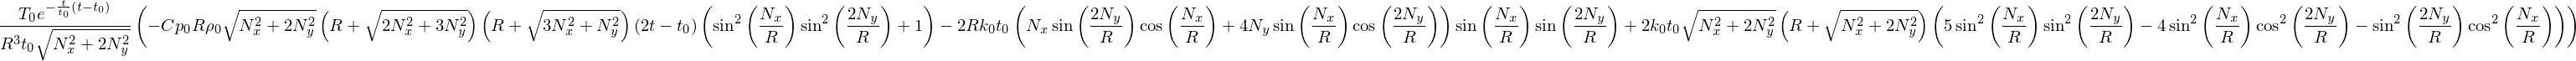

In [16]:
g_sym

# substitute coefficient values

In [17]:
subs = [(R, 3.33), (T0, 100), (Cp0, 1), (rho0, 0), (k0, 1), (t0, 1)]

In [18]:
g_sub, T_sub, k_sub, rho_sub, Cp_sub = [sym.subs(subs) for sym in (g_sym, T_sym, k_sym, rho_sym, Cp_sym)]

# generate FiPy lambda functions

In [19]:
g_fp, T_fp, k_fp, rho_fp, Cp_fp = [lambdify((N[0], N[1], t), sub, modules=fp.numerix) for sub in (g_sub, T_sub, k_sub, rho_sub, Cp_sub)]

# order in space

In [20]:
factor = 2.

In [21]:
grid_spacing = 1. * factor**fp.numerix.arange(0, -4, -1)

In [22]:
Terror2 = []
TerrorINF = []

In [23]:
dt = 0.1
for dx in grid_spacing:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    while time.value <= 2.0:
        T.updateOld()
        eq.solve(var=T, dt=dt)
        time.value = time() + dt
        
    dT = T - T_fp(xx, yy, time - dt)
    
    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dx, Terror2[-1], TerrorINF[-1]

1.0 0.502526854856 1.40546907733
0.5 0.120278992844 0.384425990507
0.25 0.0297502075179 0.0991543628278
0.125 0.0074178467265 0.0251557644638


In [24]:
from matplotlib import pyplot as plt

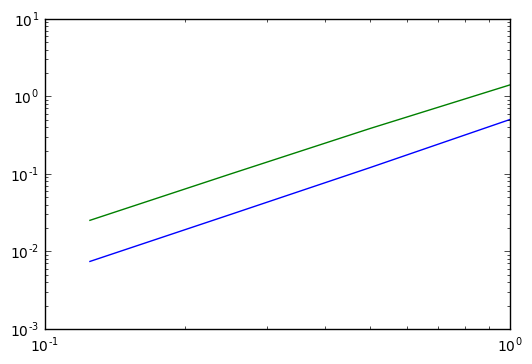

In [25]:
plt.loglog(grid_spacing, Terror2, grid_spacing, TerrorINF)

In [24]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [25]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor) - 2.

array([ 0.062816  ,  0.01541306,  0.00382737])

In [26]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor) - 2.

array([-0.12972607, -0.04504228, -0.02121278])

# order in time

In [26]:
factor = 2.

In [53]:
time_step = 1. * factor**fp.numerix.arange(0, -12, -1)

In [54]:
Terror2 = []
Terror2plus = []
Terror2minus = []
TerrorINF = []

In [55]:
dx = 0.5
for dt in time_step:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    while time.value <= 2.0:
        T.updateOld()
        time.value = time() + dt
        eq.solve(var=T, dt=dt)
        
    dT = T - T_fp(xx, yy, time)
    dTplus = T - T_fp(xx, yy, time + dt)
    dTminus = T - T_fp(xx, yy, time - dt)

    Terror2.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    Terror2plus.append(fp.numerix.L2norm(dTplus * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    Terror2minus.append(fp.numerix.L2norm(dTminus * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    TerrorINF.append(fp.numerix.LINFnorm(dT))
    
    print dt, Terror2[-1], TerrorINF[-1]

1.0 0.00164841471651 0.00526852961683
0.5 0.0156397224825 0.0499864160107
0.25 0.0399374302905 0.127644784759
0.125 0.0608973089516 0.194635053911
0.0625 0.0743220543026 0.237542139342
0.03125 0.0818662995118 0.261654445778
0.015625 0.0858580065104 0.274412416878
0.0078125 0.0879101658157 0.280971362491
0.00390625 0.088950494768 0.284296377757
0.001953125 0.0894742429413 0.285970339314
0.0009765625 0.0897370156085 0.286810192062
0.00048828125 0.0898686269182 0.287230837487


In [56]:
Terror2 = fp.numerix.array(Terror2)
TerrorINF = fp.numerix.array(TerrorINF)

In [57]:
fp.numerix.log(Terror2[:-1] / Terror2[1:]) / fp.numerix.log(factor)

array([ -3.24606376e+00,  -1.35252659e+00,  -6.08636969e-01,
        -2.87411902e-01,  -1.39479306e-01,  -6.86829914e-02,
        -3.40773303e-02,  -1.69726238e-02,  -8.46980158e-03,
        -4.23077321e-03,  -2.11435471e-03])

In [60]:
fp.numerix.log(TerrorINF[:-1] / TerrorINF[1:]) / fp.numerix.log(factor)

array([ -3.24606381e+00,  -1.35252660e+00,  -6.08636970e-01,
        -2.87411902e-01,  -1.39479306e-01,  -6.86829914e-02,
        -3.40773304e-02,  -1.69726238e-02,  -8.46980159e-03,
        -4.23077321e-03,  -2.11435471e-03])

In [58]:
Terror2plus = fp.numerix.array(Terror2plus)
fp.numerix.log(Terror2plus[:-1] / Terror2plus[1:]) / fp.numerix.log(factor)

array([-3.08892517, -0.79613564,  0.21351646,  0.64322413,  0.83163779,
        0.91555214,  0.94165773,  0.89891155,  0.71682973,  0.3914423 ,
        0.1343695 ])

In [59]:
Terror2minus = fp.numerix.array(Terror2minus)
fp.numerix.log(Terror2minus[:-1] / Terror2minus[1:]) / fp.numerix.log(factor)

array([ 0.24865589,  0.5705829 ,  0.78205615,  0.89115043,  0.94342183,
        0.9638149 ,  0.95563126,  0.89174251,  0.70668251,  0.40294133,
        0.15755041])